In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns

# Load the data
file_paths = {
    "CBOE": "CBOE.csv",
    "EMR": "EMR.csv",
    "PEP": "PEP.csv",
    "TTWO": "TTWO.csv"
}

data = {}
for ticker, path in file_paths.items():
    df = pd.read_csv(path, parse_dates=["Date"])
    df.set_index("Date", inplace=True)
    df.sort_index(inplace=True)
    data[ticker] = df

In [13]:
# 1.  CAST

# 1.1
no_diff_companies = {}
for ticker, df in data.items():
    count = (df['High'] == df['Low']).sum()
    if count > 0:
        no_diff_companies[ticker] = count

if no_diff_companies:
    for ticker, count in no_diff_companies.items():
        print(f"{ticker}: {count} day(s)")


In [7]:
# 1. 2
for ticker, df in data.items():
    max_high = df['High'].max()
    min_high = df['High'].min()
    print(f"{ticker}: Highest High = {max_high:.2f}, Lowest High = {min_high:.2f}")
print()

2. Highest and Lowest 'High' price recorded by each company:
CBOE: Highest High = 133.74, Lowest High = 65.56
EMR: Highest High = 98.75, Lowest High = 38.50
PEP: Highest High = 177.49, Lowest High = 80.43
TTWO: Highest High = 214.91, Lowest High = 50.04



In [12]:
# 1.3
returns_summary = {}
for ticker, df in data.items():
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    r = df['log_return'].dropna()
    returns_summary[ticker] = {
        "min": r.min(),
        "max": r.max(),
        "mean": r.mean(),
        "std": r.std(),
        "skewness": skew(r)
    }
print(pd.DataFrame(returns_summary).T, "\n")

           min       max      mean       std  skewness
CBOE -0.154702  0.126863  0.000428  0.017319 -0.903299
EMR  -0.210207  0.151306  0.000455  0.019179 -1.053966
PEP  -0.121353  0.121654  0.000477  0.013045 -0.637811
TTWO -0.148003  0.115275  0.000497  0.023518 -0.574339 



In [10]:
# 1.4
for ticker, df in data.items():
    r = df['log_return'].dropna()
    second_max = r.nlargest(2).index[-1]
    second_min = r.nsmallest(2).index[-1]
    print(f"{ticker}: 2nd Highest Gain = {second_max.date()}, 2nd Worst Loss = {second_min.date()}")
print()

CBOE: 2nd Highest Gain = 2020-03-19, 2nd Worst Loss = 2020-03-16
EMR: 2nd Highest Gain = 2020-03-19, 2nd Worst Loss = 2020-03-23
PEP: 2nd Highest Gain = 2020-03-13, 2nd Worst Loss = 2020-03-16
TTWO: 2nd Highest Gain = 2022-05-17, 2nd Worst Loss = 2022-11-08



In [11]:
# 1.5
for ticker, df in data.items():
    weekly_median = df['Volume'].resample('W').median().median()
    print(f"{ticker}: {weekly_median:,.0f}")
print()


CBOE: 707,500
EMR: 2,847,400
PEP: 4,248,200
TTWO: 1,499,000



In [49]:
# 1.6
total_returns = {}
for ticker, df in data.items():
    if df['Close'].iloc[0] > 0:
        total_return = df['Close'].iloc[-1] / df['Close'].iloc[0] - 1
        total_returns[ticker] = total_return

lowest_return_ticker = min(total_returns, key=total_returns.get)
print(f"{lowest_return_ticker}: {total_returns[lowest_return_ticker]:.2%}")
print()


6. Company with the lowest total return:
CBOE: 90.82%



In [50]:
# 1.7á
for ticker, df in data.items():
    df['volume_class'] = pd.qcut(df['Volume'], q=3, labels=["Low", "Medium", "High"])
print("Done.\n")


7. Creating volume_class column using tertiles (Low, Medium, High)...
Done.



8A. Plotting log returns over time...


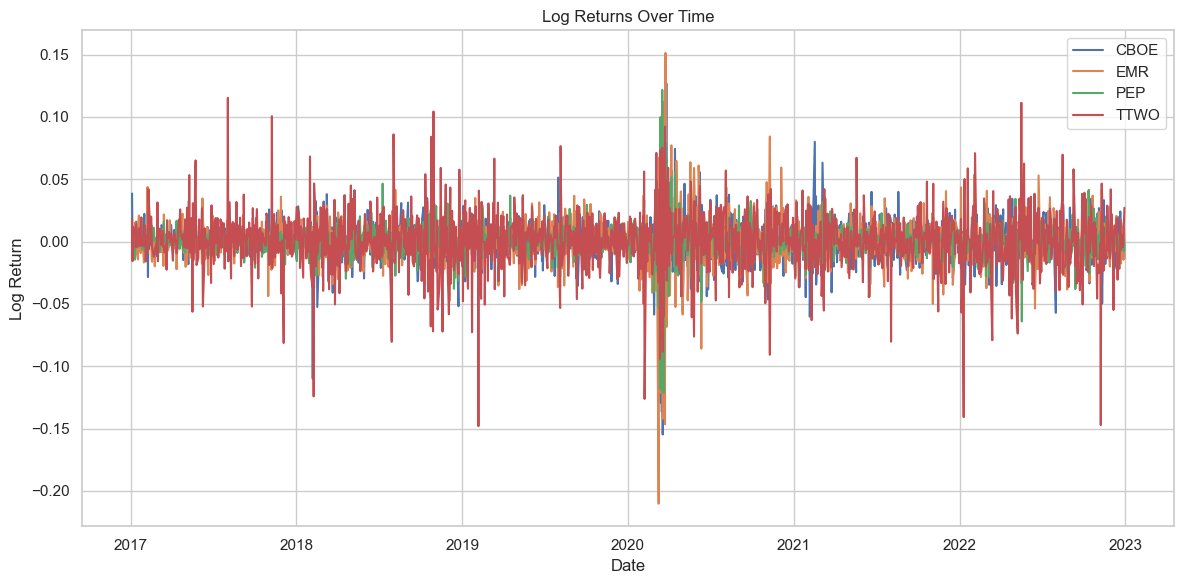

In [51]:
# 1.8a
plt.figure(figsize=(12, 6))
for ticker, df in data.items():
    plt.plot(df['log_return'], label=ticker)
plt.title("Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

8B. Plotting log-return distributions (KDE)...


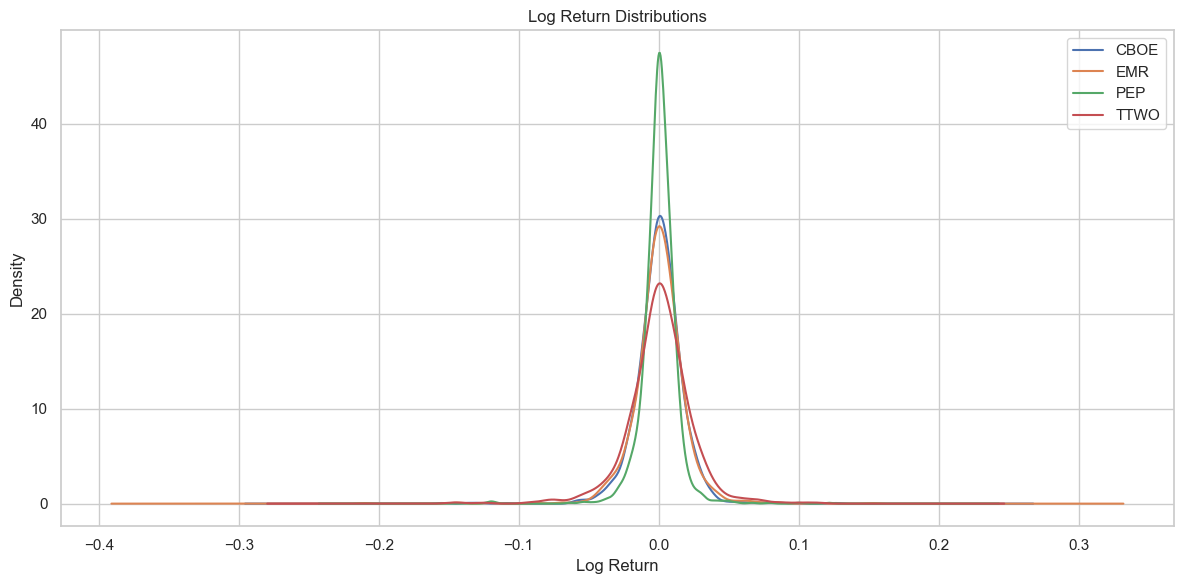

In [52]:
# 1.8bn
plt.figure(figsize=(12, 6))
for ticker, df in data.items():
    df['log_return'].dropna().plot(kind='kde', label=ticker)
plt.title("Log Return Distributions")
plt.xlabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Ě. CAST

# DATASETY
companies = pd.read_csv("companies_no_subindustry.csv")
subindustries = pd.read_csv("companies_subindustry.csv")

# 2.1
missing_included = companies['included'].isna().sum()
print(f"'included' date: {missing_included}\n")

'included' date: 45



In [57]:
# 2.2
companies['included'] = pd.to_datetime(companies['included'], dayfirst=True, errors='coerce')
cleaned = companies.dropna(subset=['included']).copy()
cleaned['age_days'] = (pd.Timestamp.today() - cleaned['included']).dt.days

# NEJMLADSI A NEJSTARSI
oldest_company = cleaned.loc[cleaned['age_days'].idxmax()]
youngest_company = cleaned.loc[cleaned['age_days'].idxmin()]
median_age_years = cleaned['age_days'].median() / 365

print("(based on inclusion date):")
print(f"- Oldest: {oldest_company['Security']} (included: {oldest_company['included'].date()})")
print(f"- Youngest: {youngest_company['Security']} (included: {youngest_company['included'].date()})")
print(f"- Median age of included companies: {median_age_years:.1f} years\n")


2. Oldest and youngest companies (based on inclusion date):
- Oldest: Altria (included: 1957-03-04)
- Youngest: Arch Capital Group (included: 2022-11-01)
- Median age of included companies: 16.7 years



In [17]:
# 2.3
print("3. Sector distribution (GICS Sector):")
sector_counts = cleaned['GICS_Sector'].value_counts()
print(sector_counts, "\n")

plt.figure(figsize=(8, 8))
sector_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title("S&P 500 Companies by GICS Sector")
plt.ylabel("")
plt.tight_layout()
plt.show()

3. Sector distribution (GICS Sector):


NameError: name 'cleaned' is not defined

In [59]:
# 2.4
print("State distribution (extracted from 'hq'):")
cleaned['state'] = cleaned['hq'].str.extract(r",\s*([A-Z]{2})$")
state_counts = cleaned['state'].value_counts()
print(state_counts.head(10), "\n")

4. State distribution (extracted from 'hq'):
state
UK    1
Name: count, dtype: int64 



In [18]:
# 2.5
joined = cleaned.merge(subindustries, on='Symbol', how='inner')
health_care = joined[joined['GICS_Sector'] == "Health Care"]
health_subindustry_counts = health_care['subindustry'].value_counts()

print("Subindustry distribution for 'Health Care' sector:")
print(health_subindustry_counts)

NameError: name 'cleaned' is not defined

In [71]:
# 3. CAST
# 3.1
np.random.seed(42)

n1 = np.random.randint(100, 501)
n2 = np.random.randint(100, 501)
n3 = np.random.randint(100, 501)
n4 = np.random.randint(100, 501)

data = {
    "Normal": np.random.normal(loc=0, scale=1, size=n1),
    "Uniform": np.random.uniform(low=0, high=10, size=n2),
    "Exponential": np.random.exponential(scale=1, size=n3),
    "Poisson": np.random.poisson(lam=4, size=n4)
}

df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))

In [ ]:
# 3.2 nezbyl mi cas
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_types = 